In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import pydrake
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()


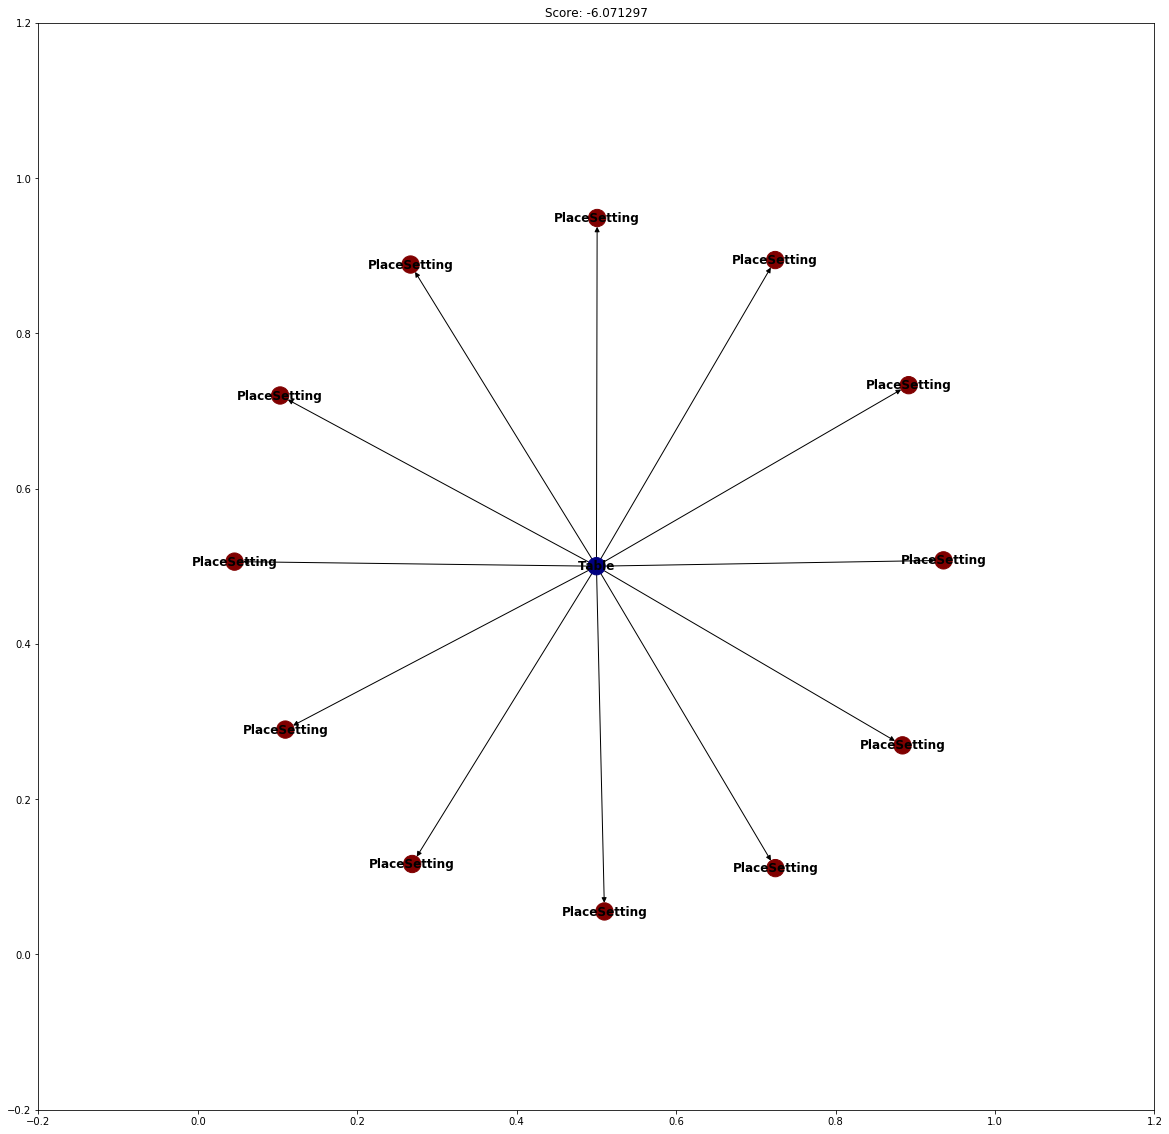

In [3]:
plt.figure().set_size_inches(20, 20)
hyper_parse_tree = generate_hyperexpanded_parse_tree()
draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)

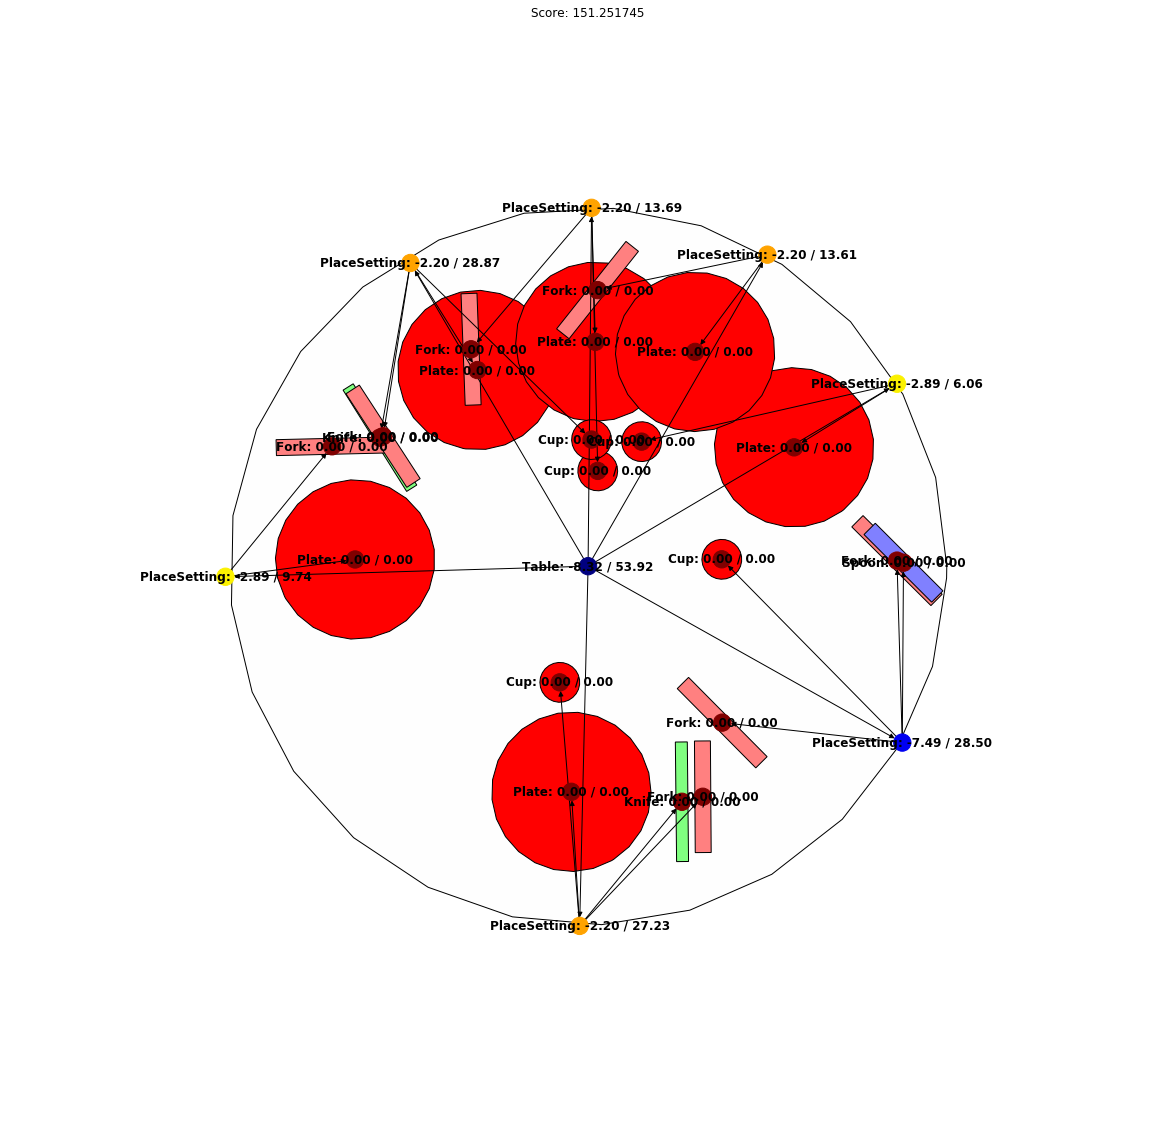

In [4]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
yaml_env = convert_tree_to_yaml_env(parse_tree)
DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [5]:
# Clear gradients
for param_name in pyro.get_param_store():
    pyro.param(param_name).grad = None
# Calc gradients of score w.r.t. all params
trace = poutine.trace(rerun_conditioned_parse_tree).get_trace(
    parse_tree, score_terminal_products=True, score_nonterminal_products=True)
score = trace.log_prob_sum()
print("score: ", score)
score.backward(retain_graph=True)
def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)
print_param_store(grads=True)
fork_node = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
#print(list(parse_tree.predecessors(fork_node))[0].offset_dist.scale)

score:  tensor(151.2517, grad_fn=<AddBackward0>)
place_setting_left_knife_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000]) , unconstrained grad:  tensor([-56.9408, -82.5824, 163.7519])
place_setting_right_spoon_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  tensor([93.2221, -1.9602, 86.4825])
place_setting_right_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  tensor([-0.1179, -0.8997, -0.2269])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000]) , unconstrained grad:  tensor([-0.9368, -2.8685, -1.3683])
place_setting_left_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000]) , unconstrained grad:  tensor([-286.1097,   14.5514,   -0.9213])
place_setting_right_knife_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  tensor([-192.4456,  -20.8849, -122.5763])
place_s

In [ ]:
fork = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
fork_prod = list(parse_tree.predecessors(fork))[0]
loc = pyro.param("place_setting_left_fork_mean") # fork_prod.offset_dist.mean
scale = pyro.param("place_setting_left_fork_var") # fork_prod.offset_dist.variance
loc.grad = None
scale.grad = None

local_score = fork_prod.score_products(list(parse_tree.predecessors(fork_prod))[0], [fork])
local_score.backward(retain_graph=True)
print(local_score)
print("Loc: ", loc, loc.grad)
print("Scale: ", scale, scale.grad)

In [ ]:
score = poutine.trace()

In [ ]:
import yaml
import multiprocessing
from functools import partial

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]

all_observed_trees = []
for env in envs[0:
    tree, score = guess_parse_tree_from_yaml(
        env, outer_iterations=10,
        num_attempts=3, verbose=False)
    print("Tree with score %f" % score)
    all_observed_trees.append(tree)

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_tree in all_observed_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    print(gt_mean, gt_std)
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    
    
print(scores_by_class)
plt.tight_layout()

In [ ]:
draw_parse_tree(all_observed_trees[2], label_name=True, label_score=True)

In [ ]:
# Perturb params
for name in pyro.get_param_store().get_all_param_names():
    data = pyro.get_param_store()._params[name].data
    data += dist.Normal(torch.zeros(data.shape), torch.ones(data.shape)*0.1).sample()

In [29]:
train_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_human_train")
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_human_test")

print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))

def rotate_yaml_env(env, r):
    rotation_origin = np.array([0.5, 0.5])
    rotmat = np.array([[np.cos(r), -np.sin(r)],
                       [np.sin(r), np.cos(r)]])
    for obj_k in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_k]
        init_pose = np.array(obj_yaml["pose"])
        init_pose[2] += r
        init_pose[2] = np.mod(init_pose[2], np.pi*2.)
        init_pose[:2] = rotmat.dot(init_pose[:2] - rotation_origin) + rotation_origin
        obj_yaml["pose"] = init_pose.tolist()

38 training examples
12 test examples


In [28]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml
from tensorboardX import SummaryWriter
import datetime

log_dir = "/home/gizatt/projects/scene_generation/models/runs/psg/table_setting/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

# setup the optimizer
adam_params = {"lr": 0.025, "betas": (0.8, 0.95)}
optimizer = Adam(adam_params)

baseline = 0.
    
param_val_history = []
score_history = []
score_test_history = []

# do gradient steps
print_param_store()
if len(score_history) > 0:
    best_loss_yet = min(score_history)
else:
    best_loss_yet = np.infty

snapshots = {}
    
def score_subset_of_dataset(dataset, n):
    losses = []
    active_param_names = set()
    for p_k in range(n):
        # Domain randomization
        env = random.choice(dataset)
        rotate_yaml_env(env, np.random.uniform(0, 2*np.pi))
        
        observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
        # Joint score is P(T, V_obs)
        # Latent score is P(T | V_obs)
        latents_score, _ = score_tree(observed_tree, include_observed=False)
        f = joint_score - latents_score
        total_score = - (latents_score * (f.detach() - baseline) + f)
        print("Obs tree with joint score %f, latents score %f, total score %f" % (joint_score, latents_score, total_score))
        losses.append(total_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in observed_tree.nodes])
    loss = torch.stack(losses).mean()
    return loss, active_param_names

for step in range(500):
    # Pick a few random environment and parse them
    loss, active_param_names = score_subset_of_dataset(train_dataset, 5)
    writer.add_scalar('loss', loss.item(), step)

    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    print("Loss: ", loss)
    #loss = svi.step(observed_tree)
    score_history.append(loss)
    
    if (step % 5 == 0):
        # Evaluate on a few test data points
        loss_test, _ = score_subset_of_dataset(test_dataset, 5)
        score_test_history.append(loss_test)
        writer.add_scalar('loss_test', loss_test.item(), step)
        print("Loss_test: ", loss_test)

        if loss_test < best_loss_yet:
            best_loss_yet = loss
            pyro.get_param_store().save("best_on_test_save.pyro")
            
        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree()
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        writer.add_figure("generated_envs", plt.gcf(), step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in active_param_names}
    for param_name in all_param_state.keys():
        write_np_array(writer, param_name, all_param_state[param_name], step)
    param_val_history.append(all_param_state)
    print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

place_setting_left_knife_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000])
place_setting_right_spoon_mean :  tensor([0.1500, 0.1600, 0.0000])
place_setting_right_spoon_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000])
place_setting_left_spoon_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000])
place_setting_right_knife_mean :  tensor([0.1500, 0.1600, 0.0000])
place_setting_right_fork_var :  tensor([0.0100, 0.0100, 0.0100])
place_setting_left_spoon_mean :  tensor([-0.1500,  0.1600,  0.0000])
place_setting_right_fork_mean :  tensor([0.1500, 0.1600, 0.0000])
place_setting_production_weights :  tensor([0.0006, 0.0006, 0.0556, 0.0006, 0.0006, 0.0006, 0.1113, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0278, 0.0006,
        0.0556, 0.0006, 0.0006, 0.0006, 0.1113, 0.0006, 0.0006, 0.0006, 0.0006,
     

Obs tree with joint score -754.104375, latents score -400.092157, total score -141283.499746
Loss_test:  tensor(-1415729.3225, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0160,  0.0270, -0.1354], requires_grad=True)
Place setting plate var:  tensor([0.0113, 0.0113, 2.7653], grad_fn=<AddBackward0>)
Obs tree with joint score -3477.794764, latents score -410.424010, total score -1255855.233650
Obs tree with joint score -5481.694765, latents score -1362.162194, total score -5607351.991968
Obs tree with joint score -1907.334078, latents score -648.990293, total score -815394.557971
Obs tree with joint score -6300.477992, latents score -771.914127, total score -4262047.985213
Obs tree with joint score -4801.640880, latents score -1601.637173, total score -5122044.886726
Loss:  -3412538.93111
Place setting plate mean:  tensor([ 0.0327,  0.0164, -0.1606], requires_grad=True)
Place setting plate var:  tensor([0.0116, 0.0115, 2.7599], grad_fn=<AddBackward0>)
Obs tree with join

Obs tree with joint score -446.301600, latents score -100.160681, total score -34323.569222
Obs tree with joint score -485.066533, latents score -49.372414, total score -21075.576448
Loss:  -82182.1343589
Place setting plate mean:  tensor([ 0.0481,  0.0854, -0.3933], requires_grad=True)
Place setting plate var:  tensor([0.0142, 0.0130, 2.7502], grad_fn=<AddBackward0>)
Obs tree with joint score -814.810060, latents score -259.863619, total score -143655.444172
Obs tree with joint score -498.679450, latents score -129.675062, total score -47481.662520
Obs tree with joint score -18420.874138, latents score -491.121920, total score -8787764.583531
Obs tree with joint score -2373.196085, latents score -424.293202, total score -824957.341776
Obs tree with joint score -5194.998148, latents score -450.649371, total score -2133293.443159
Loss:  -2387430.49503
Place setting plate mean:  tensor([ 0.0415,  0.0946, -0.4136], requires_grad=True)
Place setting plate var:  tensor([0.0145, 0.0131, 2.72

Obs tree with joint score -55.224010, latents score -35.817218, total score -675.690503
Loss:  -60319.7211182
Place setting plate mean:  tensor([-0.0589,  0.1233, -0.6117], requires_grad=True)
Place setting plate var:  tensor([0.0173, 0.0139, 2.6600], grad_fn=<AddBackward0>)
Obs tree with joint score -43.516498, latents score -13.888922, total score -381.867518
Obs tree with joint score -186.440502, latents score -18.589251, total score -2952.377776
Obs tree with joint score -553.086172, latents score -52.853730, total score -25938.917935
Obs tree with joint score -132.083993, latents score -40.406438, total score -3612.685910
Obs tree with joint score -113.791074, latents score -36.276471, total score -2734.441625
Loss:  -7124.05815269
Place setting plate mean:  tensor([-0.0691,  0.1259, -0.6271], requires_grad=True)
Place setting plate var:  tensor([0.0175, 0.0140, 2.6564], grad_fn=<AddBackward0>)
Obs tree with joint score -216.908810, latents score -118.652065, total score -11560.10

Obs tree with joint score -401.320986, latents score -15.566635, total score -5619.142987
Obs tree with joint score -14.183070, latents score -9.876607, total score -38.226780
Obs tree with joint score -149.643025, latents score -62.626839, total score -5362.532511
Obs tree with joint score -97.270448, latents score -37.834890, total score -2189.302241
Obs tree with joint score -145.755193, latents score -15.894137, total score -1934.168336
Loss:  -3028.67457115
Place setting plate mean:  tensor([-0.0375,  0.1451, -0.7953], requires_grad=True)
Place setting plate var:  tensor([0.0202, 0.0142, 2.6282], grad_fn=<AddBackward0>)
Obs tree with joint score -600.730312, latents score -18.107310, total score -9967.112174
Obs tree with joint score -105.574817, latents score -21.438343, total score -1719.610113
Obs tree with joint score -5865.650170, latents score -711.119980, total score -3660334.873337
Obs tree with joint score -98.843267, latents score -8.003448, total score -636.191955
Obs t

Obs tree with joint score -45.799698, latents score 9.019203, total score 549.241714
Obs tree with joint score -1135.213049, latents score -359.145272, total score -277945.005234
Obs tree with joint score -347.130087, latents score -9.998316, total score -3033.618259
Loss:  -66379.1409533
Obs tree with joint score -76.709314, latents score -4.222207, total score -233.568448
Obs tree with joint score -2.017974, latents score 2.596835, total score 16.598709
Obs tree with joint score -104.977741, latents score -19.499242, total score -1581.287415
Obs tree with joint score -213.350083, latents score -52.018128, total score -8230.854379
Obs tree with joint score -1360.062345, latents score -250.171780, total score -276553.407761
Loss_test:  tensor(-57316.5039, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0773,  0.1385, -0.9497], requires_grad=True)
Place setting plate var:  tensor([0.0229, 0.0144, 2.6197], grad_fn=<AddBackward0>)
Obs tree with joint score -84.413414, laten

Obs tree with joint score -75.766750, latents score -0.415715, total score 44.026443
Obs tree with joint score -149.748562, latents score -24.369479, total score -2930.043902
Obs tree with joint score -1663.551646, latents score -54.823771, total score -86587.800680
Obs tree with joint score -123.360599, latents score -14.888794, total score -1506.542530
Obs tree with joint score -66.305225, latents score -5.408619, total score -268.469928
Loss:  -18249.7661193
Place setting plate mean:  tensor([-0.0243,  0.1419, -1.0101], requires_grad=True)
Place setting plate var:  tensor([0.0254, 0.0146, 2.3785], grad_fn=<AddBackward0>)
Obs tree with joint score -201.770651, latents score -22.764516, total score -3895.981878
Obs tree with joint score -50.129099, latents score -2.818406, total score -86.030068
Obs tree with joint score -99.318727, latents score -17.071713, total score -1321.850381
Obs tree with joint score -1323.486558, latents score -160.283505, total score -185279.059117
Obs tree 

Obs tree with joint score -138.567286, latents score -12.854991, total score -1490.318082
Loss:  -182252.128654
Place setting plate mean:  tensor([ 0.0459,  0.1351, -1.0477], requires_grad=True)
Place setting plate var:  tensor([0.0285, 0.0148, 2.4467], grad_fn=<AddBackward0>)
Obs tree with joint score -41.943290, latents score -24.463528, total score -410.136886
Obs tree with joint score -138.690283, latents score -14.863017, total score -1716.619478
Obs tree with joint score -41.306080, latents score -3.648270, total score -99.728048
Obs tree with joint score 15.637727, latents score 2.789574, total score -48.689029
Obs tree with joint score -163.006484, latents score -66.461744, total score -6319.987067
Loss:  -1719.03210154
Place setting plate mean:  tensor([ 0.0506,  0.1389, -1.0451], requires_grad=True)
Place setting plate var:  tensor([0.0288, 0.0148, 2.4324], grad_fn=<AddBackward0>)
Obs tree with joint score 12.204957, latents score -6.282243, total score 97.653885
Obs tree wit

Obs tree with joint score -165.832667, latents score -33.449775, total score -4295.795077
Obs tree with joint score -0.762176, latents score -7.053692, total score 38.086899
Obs tree with joint score -6.027700, latents score -8.395355, total score 17.509646
Obs tree with joint score -833.132961, latents score -16.665273, total score -12790.189167
Loss:  -3296.77665178
Place setting plate mean:  tensor([ 0.0413,  0.1394, -1.1339], requires_grad=True)
Place setting plate var:  tensor([0.0317, 0.0150, 2.6053], grad_fn=<AddBackward0>)
Obs tree with joint score -202.217271, latents score -0.998723, total score 0.257042
Obs tree with joint score -10.664782, latents score -4.864602, total score -22.415389
Obs tree with joint score -159.255441, latents score -2.043188, total score -164.001941
Obs tree with joint score 2.088650, latents score -20.191224, total score 427.578032
Obs tree with joint score 5.792030, latents score -6.575221, total score 68.950154
Loss:  62.0735794904
Obs tree with j

Obs tree with joint score -70.989144, latents score -6.281255, total score -341.738855
Obs tree with joint score -77.040336, latents score -12.039697, total score -717.587364
Obs tree with joint score -0.764385, latents score -4.619630, total score 13.954563
Obs tree with joint score -57.400987, latents score -4.370138, total score -178.721255
Obs tree with joint score -4.858761, latents score -3.609018, total score -3.260602
Loss_test:  tensor(-245.4707, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0089,  0.1391, -1.1782], requires_grad=True)
Place setting plate var:  tensor([0.0352, 0.0152, 2.5814], grad_fn=<AddBackward0>)
Obs tree with joint score -53.710061, latents score -6.634937, total score -265.265349
Obs tree with joint score -117.919965, latents score -21.553068, total score -1980.635363
Obs tree with joint score 22.243550, latents score 2.580256, total score -70.399625
Obs tree with joint score -128.492434, latents score -16.106913, total score -1697.79828

Obs tree with joint score 35.017020, latents score -15.616925, total score 740.112573
Loss:  -9410.09324706
Place setting plate mean:  tensor([-0.0276,  0.1402, -1.2364], requires_grad=True)
Place setting plate var:  tensor([0.0386, 0.0154, 2.5926], grad_fn=<AddBackward0>)
Obs tree with joint score -5.573256, latents score -5.412214, total score -0.710555
Obs tree with joint score 12.088393, latents score -3.277058, total score 34.988023
Obs tree with joint score 2.290451, latents score 2.850138, total score 2.154872
Obs tree with joint score -204.035170, latents score -7.573931, total score -1291.522670
Obs tree with joint score -23.128168, latents score -1.142426, total score -3.131341
Loss:  -251.644334039
Place setting plate mean:  tensor([-0.0262,  0.1382, -1.2464], requires_grad=True)
Place setting plate var:  tensor([0.0389, 0.0154, 2.5947], grad_fn=<AddBackward0>)
Obs tree with joint score 32.015900, latents score -3.171489, total score 76.409015
Obs tree with joint score -37.7

Obs tree with joint score -8.333922, latents score -4.035216, total score -13.047500
Obs tree with joint score 19.397200, latents score 11.194917, total score -100.026155
Obs tree with joint score 16.891666, latents score -21.111125, total score 764.278918
Loss:  -260.219314323
Place setting plate mean:  tensor([-0.0394,  0.1343, -1.3725], requires_grad=True)
Place setting plate var:  tensor([0.0422, 0.0157, 2.4573], grad_fn=<AddBackward0>)
Obs tree with joint score 2.082807, latents score -1.494838, total score 1.770355
Obs tree with joint score 84.680128, latents score 3.108633, total score -335.147304
Obs tree with joint score -47.711349, latents score -14.016889, total score -438.597033
Obs tree with joint score -38.856071, latents score -14.697428, total score -330.911280
Obs tree with joint score 0.841046, latents score -1.678899, total score 1.710789
Loss:  -220.23489469
Place setting plate mean:  tensor([-0.0303,  0.1363, -1.3736], requires_grad=True)
Place setting plate var:  

Obs tree with joint score 12.182435, latents score 2.026046, total score -30.733700
Obs tree with joint score 46.492296, latents score -10.481526, total score 540.198795
Obs tree with joint score -36.440264, latents score -2.700532, total score -57.375494
Obs tree with joint score 26.722987, latents score 1.184260, total score -55.783228
Loss:  114.105608871
Obs tree with joint score 4.795020, latents score -6.465750, total score 61.548550
Obs tree with joint score 8.942996, latents score 6.041429, total score -20.431179
Obs tree with joint score -0.185592, latents score -5.163044, total score 20.721357
Obs tree with joint score -18.276921, latents score -17.160630, total score -18.039977
Obs tree with joint score 2.519630, latents score 4.554613, total score 11.303544
Loss_test:  tensor(11.0205, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0274,  0.1342, -1.3845], requires_grad=True)
Place setting plate var:  tensor([0.0466, 0.0158, 2.4522], grad_fn=<AddBackward0>)
O

Obs tree with joint score 40.619322, latents score 0.469731, total score -59.009105
Obs tree with joint score 18.472665, latents score -4.865666, total score 90.218191
Obs tree with joint score 12.179166, latents score -3.256962, total score 34.838761
Loss:  24.0355969273
Place setting plate mean:  tensor([ 0.0283,  0.1391, -1.2984], requires_grad=True)
Place setting plate var:  tensor([0.0497, 0.0157, 2.3609], grad_fn=<AddBackward0>)
Obs tree with joint score -32.173250, latents score -16.166193, total score -242.766123
Obs tree with joint score 14.156986, latents score -7.187773, total score 132.076507
Obs tree with joint score 44.930833, latents score -11.662114, total score 603.400431
Obs tree with joint score 5.764733, latents score -8.597176, total score 109.109963
Obs tree with joint score -662.799839, latents score -18.485063, total score -11265.884513
Loss:  -2132.81274703
Place setting plate mean:  tensor([ 0.0221,  0.1341, -1.2924], requires_grad=True)
Place setting plate va

Obs tree with joint score 10.937196, latents score -1.298221, total score 3.648861
Obs tree with joint score 18.832777, latents score 5.302104, total score -85.271713
Obs tree with joint score -8.404675, latents score -4.953124, total score -13.644409
Obs tree with joint score 36.824500, latents score 0.628724, total score -58.952926
Loss:  -55.3555680798
Place setting plate mean:  tensor([-0.0276,  0.1410, -1.2495], requires_grad=True)
Place setting plate var:  tensor([0.0522, 0.0159, 2.4402], grad_fn=<AddBackward0>)
Obs tree with joint score 42.251398, latents score 4.849971, total score -218.797264
Obs tree with joint score -3.865438, latents score -7.131592, total score 20.026725
Obs tree with joint score 5.163598, latents score -7.798379, total score 88.120424
Obs tree with joint score 26.574485, latents score -7.670358, total score 228.425358
Obs tree with joint score -166.823530, latents score -67.459927, total score -6603.697810
Loss:  -1297.18451332
Place setting plate mean:  

Obs tree with joint score 35.357585, latents score 12.767092, total score -311.005401
Obs tree with joint score 60.420194, latents score -9.115987, total score 564.354715
Obs tree with joint score 66.377546, latents score 3.724691, total score -296.015404
Obs tree with joint score 35.186374, latents score 12.682844, total score -307.912291
Obs tree with joint score 6.753953, latents score -5.607805, total score 56.960570
Loss:  -58.7235620982
Obs tree with joint score 4.120525, latents score -4.165452, total score 26.228866
Obs tree with joint score 2.985795, latents score -6.951890, total score 59.148000
Obs tree with joint score 32.611944, latents score -8.226541, total score 295.120985
Obs tree with joint score 2.741969, latents score -7.100015, total score 60.036245
Obs tree with joint score 52.641413, latents score 16.492485, total score -632.334585
Loss_test:  tensor(-38.3601, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0143,  0.1488, -1.1449], requires_grad=Tr

Obs tree with joint score 30.726301, latents score 1.971735, total score -85.450959
Obs tree with joint score 62.881014, latents score 8.983569, total score -538.088874
Obs tree with joint score 13.202606, latents score -5.806095, total score 91.357618
Obs tree with joint score 0.922829, latents score -5.460653, total score 28.474497
Loss:  -136.935931427
Place setting plate mean:  tensor([-0.0487,  0.1385, -1.1185], requires_grad=True)
Place setting plate var:  tensor([0.0560, 0.0158, 2.5727], grad_fn=<AddBackward0>)
Obs tree with joint score 5.933089, latents score -2.779579, total score 15.504886
Obs tree with joint score 24.206433, latents score 0.766532, total score -41.407326
Obs tree with joint score 21.537519, latents score 1.421021, total score -48.702467
Obs tree with joint score 29.910798, latents score -0.830095, total score -5.223042
Obs tree with joint score -4.333511, latents score 0.641374, total score 8.165647
Loss:  -14.3324603447
Place setting plate mean:  tensor([-0

Obs tree with joint score 51.425900, latents score 3.658877, total score -222.540664
Obs tree with joint score 21.776429, latents score 1.110991, total score -43.624560
Obs tree with joint score 3.318240, latents score -3.022935, total score 12.827781
Obs tree with joint score 71.841926, latents score 7.409347, total score -541.835906
Loss:  -104.879802075
Place setting plate mean:  tensor([ 0.0445,  0.1537, -1.1492], requires_grad=True)
Place setting plate var:  tensor([0.0524, 0.0165, 2.4558], grad_fn=<AddBackward0>)
Obs tree with joint score -27.007431, latents score -14.087051, total score -169.089674
Obs tree with joint score 14.958446, latents score -3.724659, total score 50.905086
Obs tree with joint score 28.808187, latents score -5.321117, total score 147.476721
Obs tree with joint score -2.470031, latents score -5.484947, total score 13.521739
Obs tree with joint score 19.902951, latents score -7.071871, total score 163.787635
Loss:  41.3203013763
Place setting plate mean:  t

Obs tree with joint score 7.054187, latents score -3.729348, total score 29.432019
Obs tree with joint score 8.586130, latents score -12.649258, total score 247.376498
Obs tree with joint score 54.405077, latents score 10.079081, total score -491.091311
Obs tree with joint score 32.672529, latents score 2.667488, total score -110.043131
Loss:  -56.1237380082
Obs tree with joint score 23.531167, latents score 4.009032, total score -97.787000
Obs tree with joint score 7.815442, latents score -7.651455, total score 102.877373
Obs tree with joint score 4.620555, latents score -12.362769, total score 192.977584
Obs tree with joint score 59.166829, latents score 5.752332, total score -360.672429
Obs tree with joint score 27.233540, latents score 0.254451, total score -33.843941
Loss_test:  tensor(-39.2897, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0045,  0.1330, -1.1824], requires_grad=True)
Place setting plate var:  tensor([0.0530, 0.0178, 2.5006], grad_fn=<AddBackward0

Obs tree with joint score 8.629469, latents score 0.345039, total score -11.142882
Obs tree with joint score 58.350981, latents score 4.978400, total score -319.082650
Obs tree with joint score -38.946354, latents score 2.774297, total score 157.466146
Loss:  -63.0556261774
Place setting plate mean:  tensor([-0.0448,  0.1295, -1.2580], requires_grad=True)
Place setting plate var:  tensor([0.0571, 0.0179, 2.6723], grad_fn=<AddBackward0>)
Obs tree with joint score 51.432600, latents score 5.476449, total score -297.632651
Obs tree with joint score 7.076983, latents score -3.292650, total score 23.773933
Obs tree with joint score 6.566950, latents score -5.280829, total score 50.718319
Obs tree with joint score 3.918631, latents score -2.464933, total score 9.351497
Obs tree with joint score 75.295142, latents score 7.067888, total score -550.449827
Loss:  -152.847745967
Place setting plate mean:  tensor([-0.0418,  0.1353, -1.2672], requires_grad=True)
Place setting plate var:  tensor([0.

Obs tree with joint score 40.587754, latents score 8.290257, total score -300.052046
Obs tree with joint score 4.199057, latents score -9.656451, total score 119.939523
Obs tree with joint score 79.061803, latents score 18.890657, total score -1196.843612
Obs tree with joint score 50.931958, latents score 16.739428, total score -606.555935
Loss:  -367.104639896
Place setting plate mean:  tensor([-0.0367,  0.1401, -1.3874], requires_grad=True)
Place setting plate var:  tensor([0.0636, 0.0176, 2.5186], grad_fn=<AddBackward0>)
Obs tree with joint score 81.931774, latents score 16.036617, total score -1122.630563
Obs tree with joint score 66.985321, latents score 13.931836, total score -792.185931
Obs tree with joint score 19.665465, latents score 0.475552, total score -28.315719
Obs tree with joint score 36.371266, latents score 14.147444, total score -336.634096
Obs tree with joint score 55.487998, latents score 14.621275, total score -638.390321
Loss:  -583.631326111
Place setting plate

Obs tree with joint score 44.376089, latents score 6.932682, total score -297.026648
Obs tree with joint score 43.824545, latents score 6.628558, total score -283.751750
Obs tree with joint score 33.991548, latents score 13.885863, total score -299.290479
Obs tree with joint score 121.727234, latents score 28.632849, total score -2758.651860
Obs tree with joint score 72.100766, latents score 15.060921, total score -916.112426
Loss:  -910.966632339
Obs tree with joint score 50.718211, latents score 14.897641, total score -569.462568
Obs tree with joint score 11.132611, latents score -7.518807, total score 121.584991
Obs tree with joint score 46.251543, latents score 12.710851, total score -459.871438
Obs tree with joint score 60.835090, latents score 11.389398, total score -612.602349
Obs tree with joint score 0.703662, latents score 8.132846, total score 67.849592
Loss_test:  tensor(-290.5004, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0371,  0.1362, -1.3094], requi

Obs tree with joint score 5.093622, latents score 13.001419, total score 110.720384
Obs tree with joint score 47.193272, latents score 16.828054, total score -541.352746
Obs tree with joint score 7.689940, latents score 2.149863, total score -17.450482
Obs tree with joint score 73.272893, latents score 22.025870, total score -1180.007301
Obs tree with joint score 59.910768, latents score 24.591319, total score -903.871296
Loss:  -506.392288193
Place setting plate mean:  tensor([-0.0163,  0.1380, -1.2444], requires_grad=True)
Place setting plate var:  tensor([0.0593, 0.0153, 2.3125], grad_fn=<AddBackward0>)
Obs tree with joint score 11.827387, latents score 3.259741, total score -36.495952
Obs tree with joint score 38.199347, latents score 11.413590, total score -332.507411
Obs tree with joint score 45.383265, latents score 15.791416, total score -496.889041
Obs tree with joint score 31.588941, latents score 3.099445, total score -116.791112
Obs tree with joint score 98.891321, latents 

Place setting plate mean:  tensor([-0.0368,  0.1416, -1.4122], requires_grad=True)
Place setting plate var:  tensor([0.0555, 0.0136, 2.3009], grad_fn=<AddBackward0>)
Obs tree with joint score 20.704462, latents score 5.673461, total score -100.308797
Obs tree with joint score 42.771485, latents score 15.416335, total score -449.071305
Obs tree with joint score 36.026272, latents score 11.490967, total score -306.469693
Obs tree with joint score 44.924469, latents score 15.629252, total score -487.157538
Obs tree with joint score 46.250747, latents score 24.823543, total score -553.326336
Loss:  -379.266733664
Place setting plate mean:  tensor([-0.0560,  0.1453, -1.4227], requires_grad=True)
Place setting plate var:  tensor([0.0552, 0.0135, 2.3124], grad_fn=<AddBackward0>)
Obs tree with joint score 40.076115, latents score 8.073986, total score -290.386880
Obs tree with joint score 82.672868, latents score 21.973967, total score -1394.494527
Obs tree with joint score 46.891820, latents 

Obs tree with joint score 102.779750, latents score 37.876156, total score -2523.202263
Loss:  -1472.53255564
Place setting plate mean:  tensor([-0.0089,  0.1454, -1.4700], requires_grad=True)
Place setting plate var:  tensor([0.0540, 0.0130, 2.5129], grad_fn=<AddBackward0>)
Obs tree with joint score 30.470227, latents score 8.403724, total score -207.507299
Obs tree with joint score 87.403047, latents score 22.405451, total score -1521.298055
Obs tree with joint score 17.298088, latents score 3.667779, total score -63.623269
Obs tree with joint score 52.731892, latents score 19.989994, total score -687.252238
Obs tree with joint score 43.146782, latents score 18.474605, total score -480.480904
Loss:  -592.03235295
Obs tree with joint score 36.330397, latents score 15.644888, total score -344.307985
Obs tree with joint score 40.125917, latents score 16.161735, total score -411.266942
Obs tree with joint score 47.473781, latents score 16.817077, total score -546.212848
Obs tree with joi

Obs tree with joint score 33.114508, latents score 18.508217, total score -284.942691
Loss_test:  tensor(-148.1742, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([ 0.0371,  0.1270, -1.5570], requires_grad=True)
Place setting plate var:  tensor([0.0582, 0.0132, 2.3283], grad_fn=<AddBackward0>)
Obs tree with joint score 84.431049, latents score 23.148446, total score -1479.879644
Obs tree with joint score 57.035646, latents score 20.125382, total score -779.743423
Obs tree with joint score 11.617989, latents score 5.156517, total score -39.780163
Obs tree with joint score 40.771989, latents score 18.034979, total score -432.798513
Obs tree with joint score 45.274756, latents score 21.865267, total score -535.264210
Loss:  -653.493190416
Place setting plate mean:  tensor([ 0.0362,  0.1231, -1.5487], requires_grad=True)
Place setting plate var:  tensor([0.0585, 0.0132, 2.3211], grad_fn=<AddBackward0>)
Obs tree with joint score 128.344053, latents score 40.191690, total score -

Obs tree with joint score 50.085751, latents score 28.509970, total score -636.700641
Obs tree with joint score 54.945262, latents score 23.285149, total score -768.870569
Obs tree with joint score 18.451907, latents score 1.624049, total score -44.157127
Loss:  -1425.20040432
Place setting plate mean:  tensor([ 0.0020,  0.1419, -1.4635], requires_grad=True)
Place setting plate var:  tensor([0.0609, 0.0154, 2.3243], grad_fn=<AddBackward0>)
Obs tree with joint score 94.525368, latents score 28.586788, total score -1950.910806
Obs tree with joint score 52.470356, latents score 22.020613, total score -700.971746
Obs tree with joint score 46.632244, latents score 23.307394, total score -566.966315
Obs tree with joint score 24.044762, latents score 11.329576, total score -156.772849
Obs tree with joint score 100.632302, latents score 40.235999, total score -2490.501875
Loss:  -1173.22471807
Place setting plate mean:  tensor([ 3.2731e-04,  1.4658e-01, -1.4576e+00], requires_grad=True)
Place 

Obs tree with joint score 30.963680, latents score 9.881757, total score -229.408366
Obs tree with joint score 116.196452, latents score 43.733721, total score -3241.527602
Obs tree with joint score 57.289248, latents score 33.198609, total score -823.866334
Obs tree with joint score 112.469372, latents score 46.101372, total score -3126.023870
Obs tree with joint score 73.387928, latents score 36.458912, total score -1383.320778
Loss:  -1760.82939018
Place setting plate mean:  tensor([-0.0301,  0.1447, -1.3163], requires_grad=True)
Place setting plate var:  tensor([0.0648, 0.0162, 2.5838], grad_fn=<AddBackward0>)
Obs tree with joint score 44.478846, latents score 22.825919, total score -515.900886
Obs tree with joint score 48.503404, latents score 32.631548, total score -533.795075
Obs tree with joint score 102.851056, latents score 43.138734, total score -2635.626298
Obs tree with joint score 28.472145, latents score 15.143869, total score -215.169945
Obs tree with joint score 30.819

Obs tree with joint score 14.029325, latents score 2.863432, total score -43.138664
Obs tree with joint score 50.604886, latents score 18.446033, total score -625.362106
Obs tree with joint score 67.028914, latents score 21.707313, total score -1029.131781
Obs tree with joint score 47.742914, latents score 18.367815, total score -568.931476
Obs tree with joint score 44.846883, latents score 22.094307, total score -525.454968
Loss_test:  tensor(-558.4038, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0187,  0.1437, -1.2166], requires_grad=True)
Place setting plate var:  tensor([0.0665, 0.0167, 2.4924], grad_fn=<AddBackward0>)
Obs tree with joint score 66.841384, latents score 26.845453, total score -1113.704831
Obs tree with joint score 51.219902, latents score 34.070308, total score -601.441553
Obs tree with joint score 52.835501, latents score 32.968810, total score -674.847842
Obs tree with joint score 86.743141, latents score 29.615151, total score -1748.982051
Obs 

Place setting plate mean:  tensor([-0.0121,  0.1419, -1.1587], requires_grad=True)
Place setting plate var:  tensor([0.0750, 0.0160, 2.4762], grad_fn=<AddBackward0>)
Obs tree with joint score 105.359387, latents score 30.929834, total score -2376.523253
Obs tree with joint score 96.926635, latents score 39.267139, total score -2321.782926
Obs tree with joint score 47.222743, latents score 20.975969, total score -576.798286
Obs tree with joint score 46.805920, latents score 17.379465, total score -540.842498
Obs tree with joint score 77.931795, latents score 35.630632, total score -1549.518340
Loss:  -1473.09306059
Place setting plate mean:  tensor([-0.0153,  0.1428, -1.1690], requires_grad=True)
Place setting plate var:  tensor([0.0747, 0.0159, 2.4946], grad_fn=<AddBackward0>)
Obs tree with joint score 46.724059, latents score 27.702750, total score -545.963867
Obs tree with joint score 69.015730, latents score 31.831520, total score -1220.814142
Obs tree with joint score 67.644396, la

Obs tree with joint score 105.762792, latents score 30.273426, total score -2360.811070
Obs tree with joint score 58.243030, latents score 19.324358, total score -790.997036
Loss:  -1409.27360071
Place setting plate mean:  tensor([ 0.0133,  0.1301, -1.1969], requires_grad=True)
Place setting plate var:  tensor([0.0723, 0.0140, 2.6339], grad_fn=<AddBackward0>)
Obs tree with joint score 59.189168, latents score 30.606025, total score -903.399537
Obs tree with joint score 53.100283, latents score 29.063194, total score -722.631671
Obs tree with joint score 53.326901, latents score 33.203881, total score -688.285368
Obs tree with joint score 72.184586, latents score 35.068973, total score -1338.722053
Obs tree with joint score 71.387761, latents score 27.065849, total score -1243.932110
Loss:  -979.394147736
Place setting plate mean:  tensor([ 0.0162,  0.1297, -1.2020], requires_grad=True)
Place setting plate var:  tensor([0.0720, 0.0139, 2.6063], grad_fn=<AddBackward0>)
Obs tree with join

Obs tree with joint score 57.805462, latents score 41.383788, total score -696.012765
Obs tree with joint score 29.436307, latents score 10.014338, total score -213.920128
Obs tree with joint score 58.449785, latents score 27.780340, total score -882.677063
Obs tree with joint score 40.940695, latents score 23.418853, total score -427.863283
Loss:  -1032.64540042
Obs tree with joint score 73.939640, latents score 40.240070, total score -1389.772628
Obs tree with joint score 94.730883, latents score 46.853112, total score -2291.100347
Obs tree with joint score 48.726554, latents score 27.156084, total score -607.339958
Obs tree with joint score 67.228083, latents score 34.280087, total score -1162.408175
Obs tree with joint score 75.046236, latents score 34.251058, total score -1438.073171
Loss_test:  tensor(-1377.7389, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0672,  0.1467, -1.2341], requires_grad=True)
Place setting plate var:  tensor([0.0706, 0.0121, 2.4513], gr

Obs tree with joint score 75.411300, latents score 36.370841, total score -1458.974773
Obs tree with joint score 26.097555, latents score 11.905298, total score -183.155312
Obs tree with joint score 99.072752, latents score 39.607577, total score -2414.736666
Obs tree with joint score 95.754979, latents score 46.531134, total score -2339.665180
Obs tree with joint score 92.501359, latents score 39.202140, total score -2142.742663
Loss:  -1707.85491863
Place setting plate mean:  tensor([ 0.0207,  0.1409, -1.2437], requires_grad=True)
Place setting plate var:  tensor([0.0755, 0.0096, 2.7049], grad_fn=<AddBackward0>)
Obs tree with joint score 80.970385, latents score 48.674831, total score -1604.276211
Obs tree with joint score 83.780355, latents score 32.641452, total score -1720.386958
Obs tree with joint score 124.853290, latents score 48.483625, total score -3779.047869
Obs tree with joint score 88.221041, latents score 56.942886, total score -1812.346550
Obs tree with joint score 48.

Place setting plate mean:  tensor([-0.0142,  0.1405, -1.2355], requires_grad=True)
Place setting plate var:  tensor([0.0763, 0.0073, 2.6491], grad_fn=<AddBackward0>)
Obs tree with joint score 63.350428, latents score 40.058471, total score -956.332145
Obs tree with joint score 48.401687, latents score 25.900054, total score -605.295134
Obs tree with joint score -13.832755, latents score 30.965919, total score 1432.030801
Obs tree with joint score 75.362332, latents score 35.231197, total score -1453.999065
Obs tree with joint score 109.333789, latents score 35.237374, total score -2685.059536
Loss:  -853.731015746
Place setting plate mean:  tensor([-0.0169,  0.1467, -1.2291], requires_grad=True)
Place setting plate var:  tensor([0.0757, 0.0071, 2.6380], grad_fn=<AddBackward0>)
Obs tree with joint score 56.713559, latents score 28.332397, total score -832.487515
Obs tree with joint score 66.998072, latents score 32.463148, total score -1155.647265
Obs tree with joint score 27.018674, la

Obs tree with joint score 114.507031, latents score 35.891620, total score -2900.249834
Obs tree with joint score 85.269412, latents score 37.769453, total score -1841.547415
Loss:  -1659.63796625
Place setting plate mean:  tensor([ 0.0057,  0.1601, -1.1666], requires_grad=True)
Place setting plate var:  tensor([0.0798, 0.0075, 2.5022], grad_fn=<AddBackward0>)
Obs tree with joint score 107.845527, latents score 44.737046, total score -2886.395499
Obs tree with joint score 45.195716, latents score 21.580715, total score -533.243616
Obs tree with joint score 79.717109, latents score 38.290261, total score -1627.671658
Obs tree with joint score 47.216578, latents score 22.786740, total score -581.106216
Obs tree with joint score 58.898711, latents score 30.351686, total score -894.997361
Loss:  -1304.68286981
Obs tree with joint score 3.493973, latents score 19.072279, total score 312.692123
Obs tree with joint score 47.830774, latents score 24.877601, total score -593.973043
Obs tree wit

Obs tree with joint score 65.902127, latents score 38.939886, total score -1076.868819
Obs tree with joint score 23.618724, latents score 9.577967, total score -148.522664
Loss_test:  tensor(-898.0885, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0030,  0.1457, -1.1288], requires_grad=True)
Place setting plate var:  tensor([0.0932, 0.0072, 2.4242], grad_fn=<AddBackward0>)
Obs tree with joint score 84.293539, latents score 34.508036, total score -1767.785442
Obs tree with joint score 79.545567, latents score 27.752951, total score -1489.190549
Obs tree with joint score 62.844485, latents score 29.157410, total score -1015.914922
Obs tree with joint score 108.873894, latents score 45.049331, total score -2939.078425
Obs tree with joint score 58.552437, latents score 41.196016, total score -732.371825
Loss:  -1588.86823255
Place setting plate mean:  tensor([ 0.0030,  0.1448, -1.1364], requires_grad=True)
Place setting plate var:  tensor([0.0941, 0.0072, 2.4198], grad_fn=

Obs tree with joint score 39.487991, latents score 22.110289, total score -401.603715
Obs tree with joint score 42.490214, latents score 24.732140, total score -456.953252
Obs tree with joint score 99.174523, latents score 38.991617, total score -2406.811733
Obs tree with joint score 77.897865, latents score 32.155375, total score -1516.609399
Obs tree with joint score 15.281511, latents score 8.741265, total score -63.710273
Loss:  -969.137674237
Place setting plate mean:  tensor([ 0.0029,  0.1269, -1.2538], requires_grad=True)
Place setting plate var:  tensor([0.0944, 0.0074, 2.4860], grad_fn=<AddBackward0>)
Obs tree with joint score 98.674758, latents score 39.458106, total score -2395.793573
Obs tree with joint score 15.157322, latents score 8.968729, total score -61.692408
Obs tree with joint score 123.663167, latents score 57.656410, total score -3871.719374
Obs tree with joint score 109.506093, latents score 46.545695, total score -2993.495869
Obs tree with joint score 50.107155

Place setting plate mean:  tensor([-0.0139,  0.1280, -1.2695], requires_grad=True)
Place setting plate var:  tensor([0.1001, 0.0072, 2.6039], grad_fn=<AddBackward0>)
Obs tree with joint score 104.779229, latents score 48.422179, total score -2785.288207
Obs tree with joint score 73.957276, latents score 42.960689, total score -1362.631303
Obs tree with joint score 115.070879, latents score 54.759497, total score -3362.932304
Obs tree with joint score 50.650908, latents score 31.989389, total score -615.632090
Obs tree with joint score 70.023521, latents score 28.639859, total score -1226.605898
Loss:  -1870.61796034
Place setting plate mean:  tensor([-0.0154,  0.1284, -1.2696], requires_grad=True)
Place setting plate var:  tensor([0.0999, 0.0072, 2.5759], grad_fn=<AddBackward0>)
Obs tree with joint score 55.007487, latents score 22.420132, total score -763.200158
Obs tree with joint score 57.435436, latents score 25.725571, total score -847.464263
Obs tree with joint score 50.932532, l

Obs tree with joint score 85.395510, latents score 39.253248, total score -1857.375928
Obs tree with joint score 73.859066, latents score 32.822835, total score -1387.961659
Loss:  -1460.41610596
Obs tree with joint score 67.755357, latents score 29.085052, total score -1163.398144
Obs tree with joint score 47.876464, latents score 36.397944, total score -429.273071
Obs tree with joint score 50.477453, latents score 29.750318, total score -637.366004
Obs tree with joint score 67.723412, latents score 39.142728, total score -1147.306617
Obs tree with joint score 78.607177, latents score 38.324078, total score -1584.095718
Loss_test:  tensor(-992.2879, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0609,  0.1453, -1.3475], requires_grad=True)
Place setting plate var:  tensor([0.0930, 0.0072, 2.4260], grad_fn=<AddBackward0>)
Obs tree with joint score 50.303757, latents score 33.351575, total score -582.334159
Obs tree with joint score 89.547832, latents score 33.016194, to

Obs tree with joint score 93.243648, latents score 40.624257, total score -2190.243048
Obs tree with joint score 54.747092, latents score 22.391032, total score -756.841637
Loss:  -1529.10517317
Place setting plate mean:  tensor([ 0.0202,  0.1400, -1.2202], requires_grad=True)
Place setting plate var:  tensor([0.0916, 0.0072, 2.5507], grad_fn=<AddBackward0>)
Obs tree with joint score 61.527972, latents score 37.576722, total score -923.960718
Obs tree with joint score 80.237129, latents score 37.862589, total score -1646.784346
Obs tree with joint score 22.574725, latents score 26.957618, total score 122.535255
Obs tree with joint score 34.894918, latents score 18.159955, total score -320.641131
Obs tree with joint score 45.539091, latents score 29.798517, total score -484.786345
Loss:  -650.727457025
Place setting plate mean:  tensor([ 0.0251,  0.1370, -1.2189], requires_grad=True)
Place setting plate var:  tensor([0.0907, 0.0071, 2.5534], grad_fn=<AddBackward0>)
Obs tree with joint s

Obs tree with joint score 16.728199, latents score 10.454640, total score -71.861362
Obs tree with joint score 55.045708, latents score 27.317999, total score -785.193248
Obs tree with joint score 78.548100, latents score 49.624104, total score -1464.251404
Obs tree with joint score 45.080752, latents score 25.345128, total score -519.937549
Loss:  -787.291248463
Place setting plate mean:  tensor([-0.0229,  0.1546, -1.2414], requires_grad=True)
Place setting plate var:  tensor([0.0828, 0.0077, 2.3398], grad_fn=<AddBackward0>)
Obs tree with joint score 55.651145, latents score 29.365821, total score -798.175431
Obs tree with joint score 81.847002, latents score 40.189829, total score -1715.851827
Obs tree with joint score 63.139940, latents score 43.862616, total score -864.831166
Obs tree with joint score 18.656066, latents score 10.979826, total score -91.960015
Obs tree with joint score 99.023078, latents score 56.978675, total score -2437.678777
Loss:  -1181.69944293
Place setting p

Obs tree with joint score 110.688128, latents score 34.338998, total score -2698.101721
Obs tree with joint score 75.144627, latents score 44.402519, total score -1395.769143
Obs tree with joint score 107.777741, latents score 46.297500, total score -2907.861697
Obs tree with joint score 75.625544, latents score 43.189781, total score -1433.329250
Obs tree with joint score 80.838703, latents score 43.749238, total score -1659.725292
Loss:  -2018.95742049
Obs tree with joint score 88.989618, latents score 47.214679, total score -2014.165295
Obs tree with joint score 53.053982, latents score 27.856876, total score -727.109762
Obs tree with joint score 48.440060, latents score 33.587346, total score -513.715946
Obs tree with joint score 85.593699, latents score 44.967762, total score -1867.483387
Obs tree with joint score 85.319769, latents score 56.260218, total score -1663.956206
Loss_test:  tensor(-1357.2861, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0053,  0.1462,

Obs tree with joint score 92.955379, latents score 44.253245, total score -2203.929581
Obs tree with joint score 60.653327, latents score 34.352396, total score -929.800918
Obs tree with joint score 45.421171, latents score 22.793800, total score -538.391133
Obs tree with joint score 99.158715, latents score 43.771996, total score -2479.773982
Obs tree with joint score 33.555329, latents score 22.790042, total score -256.106623
Loss:  -1281.60044741
Place setting plate mean:  tensor([-0.0469,  0.1588, -1.3470], requires_grad=True)
Place setting plate var:  tensor([0.0834, 0.0070, 2.3657], grad_fn=<AddBackward0>)
Obs tree with joint score 64.353161, latents score 35.113098, total score -1055.949249
Obs tree with joint score 94.943572, latents score 37.568915, total score -2212.878265
Obs tree with joint score 88.107548, latents score 48.501006, total score -1960.563685
Obs tree with joint score 80.563556, latents score 49.510227, total score -1568.510676
Obs tree with joint score 78.049

Place setting plate mean:  tensor([ 0.0236,  0.1648, -1.2949], requires_grad=True)
Place setting plate var:  tensor([0.0861, 0.0075, 2.3202], grad_fn=<AddBackward0>)
Obs tree with joint score 61.811736, latents score 39.589090, total score -901.996984
Obs tree with joint score 26.916236, latents score 19.653720, total score -149.997986
Obs tree with joint score 78.066131, latents score 42.763331, total score -1544.968112
Obs tree with joint score 66.697045, latents score 35.287882, total score -1139.772005
Obs tree with joint score 52.699244, latents score 36.596004, total score -605.417459
Loss:  -868.430508921
Place setting plate mean:  tensor([ 0.0351,  0.1667, -1.2812], requires_grad=True)
Place setting plate var:  tensor([0.0867, 0.0075, 2.3517], grad_fn=<AddBackward0>)
Obs tree with joint score 13.373090, latents score 9.190318, total score -42.623780
Obs tree with joint score 77.159333, latents score 52.833059, total score -1309.557778
Obs tree with joint score 13.898179, latent

Obs tree with joint score 88.185690, latents score 53.129708, total score -1897.570042
Obs tree with joint score 51.748353, latents score 30.649564, total score -667.767466
Loss:  -1284.7780377
Place setting plate mean:  tensor([-0.0325,  0.1486, -1.3248], requires_grad=True)
Place setting plate var:  tensor([0.0902, 0.0072, 2.5542], grad_fn=<AddBackward0>)
Final loss:  -1284.7780377
place_setting_left_knife_var :  tensor([0.0661, 0.0235, 0.0228])
place_setting_left_fork_mean :  tensor([-0.1014,  0.7391,  0.2931])
place_setting_right_spoon_mean :  tensor([ 0.2072,  0.6183, -0.9777])
place_setting_right_spoon_var :  tensor([0.1736, 0.0962, 0.2818])
place_setting_plate_var :  tensor([0.0902, 0.0072, 2.5542])
place_setting_left_spoon_var :  tensor([0.0242, 0.0158, 0.0163])
place_setting_plate_mean :  tensor([-0.0325,  0.1486, -1.3248])
place_setting_right_knife_mean :  tensor([ 0.3078,  0.4708, -1.2802])
place_setting_right_fork_var :  tensor([0.0079, 0.1212, 0.5940])
place_setting_left_s

['place_setting_left_knife_var', 'place_setting_left_fork_mean', 'place_setting_right_spoon_mean', 'place_setting_right_spoon_var', 'place_setting_plate_var', 'place_setting_left_spoon_var', 'place_setting_plate_mean', 'place_setting_right_knife_mean', 'place_setting_right_fork_var', 'place_setting_left_spoon_mean', 'place_setting_right_fork_mean', 'place_setting_production_weights', 'place_setting_right_knife_var', 'place_setting_cup_var', 'place_setting_left_fork_var', 'place_setting_left_knife_mean', 'table_production_weights', 'place_setting_cup_mean']
(3, 500)
(3, 500)
(3, 436)
(3, 436)
(3, 500)
(3, 500)
(3, 500)
(3, 500)


ValueError: need at least one array to concatenate

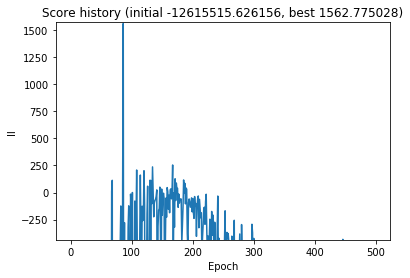

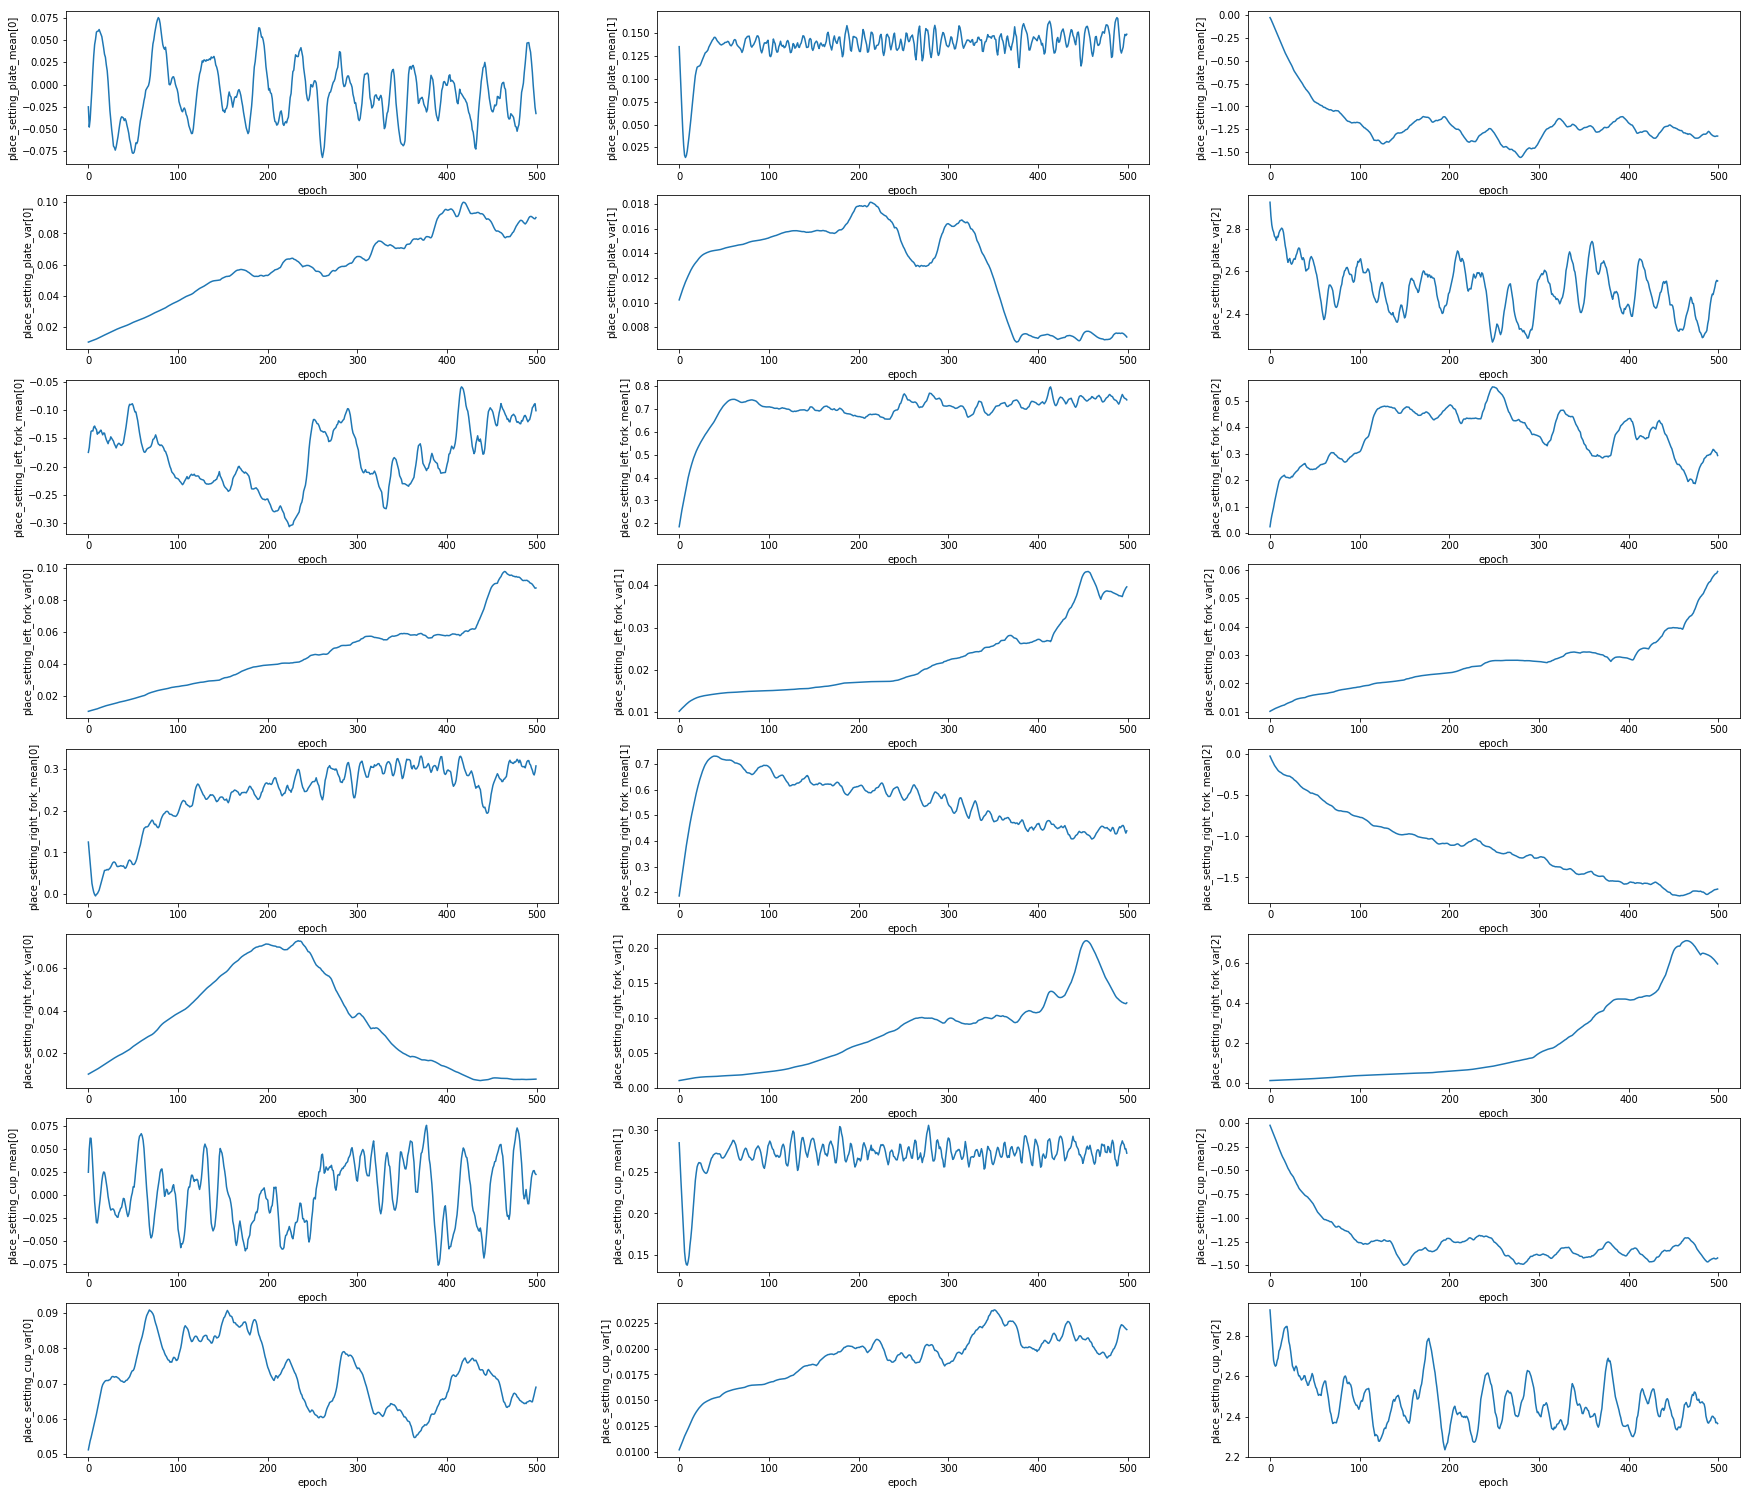

In [30]:
scores_over_time_adjusted = np.array(score_history)
max_score = np.max(scores_over_time_adjusted)
#scores_over_time_adjusted = np.log(scores_over_time_adjusted - min_score + 1.)
plt.plot(score_history)
plt.title("Score history (initial %f, best %f)" % (score_history[0], max_score))
plt.ylabel("ll")
plt.xlabel("Epoch")
plt.ylim(max_score - 2000, max_score + 10)
print(pyro.get_param_store().get_all_param_names())
names_of_interest = ["place_setting_plate_mean", "place_setting_plate_var", 
                     "place_setting_left_fork_mean", "place_setting_left_fork_var",
                     "place_setting_right_fork_mean", "place_setting_right_fork_var",
                     #"place_setting_left_spoon_mean", "place_setting_left_spoon_var",
                     #"place_setting_right_spoon_mean", "place_setting_right_spoon_var",
                     "place_setting_cup_mean", "place_setting_cup_var",
                     #"place_setting_production_weights",
                     "table_independent_set_production_probs"]
plt.figure().set_size_inches(30, 30)
for i, name in enumerate(names_of_interest):
    val_epochs = [k for k, d in enumerate(param_val_history) if name in d.keys()]
    vals_across_time = np.vstack([d[name] for d in param_val_history if name in d.keys()]).T
    print(vals_across_time.shape)
    num_vals = vals_across_time.shape[0]
    for j in range(num_vals):
        plt.subplot(len(names_of_interest), num_vals, i*num_vals + j + 1)
        plt.plot(val_epochs, vals_across_time[j, :])
        plt.ylabel(name + "[%d]" % j)
        plt.xlabel("epoch")
#plt.tight_layout()

In [ ]:
import scene_generation.data.dataset_utils as dataset_utils

# Score the outlier dataset
outlier_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_generated_with_left_knife_and_spoon_rules.yaml")
scores_outlier = []
observed_trees_outlier = []
for i, env in enumerate(outlier_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_outlier.append(observed_tree)
    scores_outlier.append(joint_score.item())
    print("Scored outlier %d at %f" % (i, joint_score))
    
# Score the test dataset
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_test")
scores_test = []
observed_trees_test = []
for i, env in enumerate(test_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_test.append(observed_tree)
    scores_test.append(joint_score.item())
    print("Scored test %d at %f" % (i, joint_score))

In [ ]:
# Sort
inds_in_ascending_order = np.argsort(scores_outlier)

plt.figure().set_size_inches(6, 3)
bins = np.arange(min(np.min(scores_outlier), np.min(scores_test)),
                 max(np.max(scores_outlier), np.max(scores_test)), 20)
plt.hist(scores_test, normed=True, bins=10, label="test", alpha=0.75)
plt.hist(scores_ascending, normed=True, bins=20, label="outliers", alpha=0.75)
plt.title("Score histogram across example")
plt.ylabel("Ratio")
plt.xlabel("LL")
plt.legend()

plt.figure().set_size_inches(20, 20)
for i in range(3):
    for j in range(3):
        ind = i*3 + j
        plt.subplot(3, 3, ind + 1)
        ind_into_orig = inds_in_ascending_order[ind]
        plt.title("Score %f" % scores_outlier[ind_into_orig])
        DrawYamlEnvironmentPlanar(outlier_dataset[ind_into_orig], base_environment_type="table_setting", ax=plt.gca())
        draw_parse_tree(observed_trees_outlier[ind_into_orig], label_name=True, label_score=True)

In [ ]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(50):
    plt.gca().clear()
    trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
    parse_tree = trace.nodes["_RETURN"]["value"]        
    score = trace.log_prob_sum()
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    #draw_parse_tree(parse_tree, label_name=False, label_score=False)
    plt.title("")
    plt.gca().axis('off')
    images.append(dataset_utils.fig2data(plt.gcf()).copy())
plt.gca().clear()
for im in images:
    plt.imshow(im, alpha=0.25)
plt.gca().axis('off')

In [ ]:
# Generate a bunch of envs + their parse trees
generated_envs_and_trees = []
for k in range(100):
    parse_tree = generate_unconditioned_parse_tree()
    generated_envs_and_trees.append((
        convert_tree_to_yaml_env(parse_tree),
        parse_tree))

In [ ]:
# Instead train on environments in which I have perfect parse trees
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.5, 0.5)}
optimizer = Adam(adam_params)
    
pyro.param("place_setting_left_fork_mean").data[0] = 0.0
# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    random.shuffle(generated_envs_and_trees)
    for env, best_observed_tree in generated_envs_and_trees[:5]:
        best_score, _ = score_tree(best_observed_tree)
        losses.append(-1. * best_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in best_observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    #print("Val: ", pyro.param("place_setting_left_fork_mean").detach().cpu().numpy())
    #print("Grad: ", pyro.get_param_store()._params["place_setting_left_fork_mean"].grad)
    #for param in params:
    #   param.data + param.grad*100
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    #print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

In [ ]:
pyro.get_param_store()._params["place_setting_left_fork_var"]

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_env, observed_tree in generated_envs_and_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    

plt.tight_layout()